**Proyecto Final**

Diego felipe Benavides



**Resumen de Proyecto**

Se pretende usar herramientas relacionadas con PLN en la base de datos llamada Noticias, de esta forma se busca identificar patrones y evaluar jerga y lenguaje periodístico.

El objetivo de este proyecto es elavorar técnicas de análisis de texto.

Este proyecto cuenta con las fases:
- preprocesamiento.
- Análisis de exploración.
- Vectorizado y modelado.

Estocon la intención de probvar las diferentes técnicas vistas en clase evaluando grandes volúmenes de texto.

**Ejercicio 1**

**Importar librerías:**

In [5]:
# Importar las bibliotecas necesarias
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dfbat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dfbat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dfbat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Carga de Datos**

In [7]:
# Cargar el archivo de datos
file_path = '../Datos/Datos Crudos/Noticias.xlsx'
data = pd.read_excel(file_path)

# Mostrar una vista previa de los datos
data.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta
0,0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo


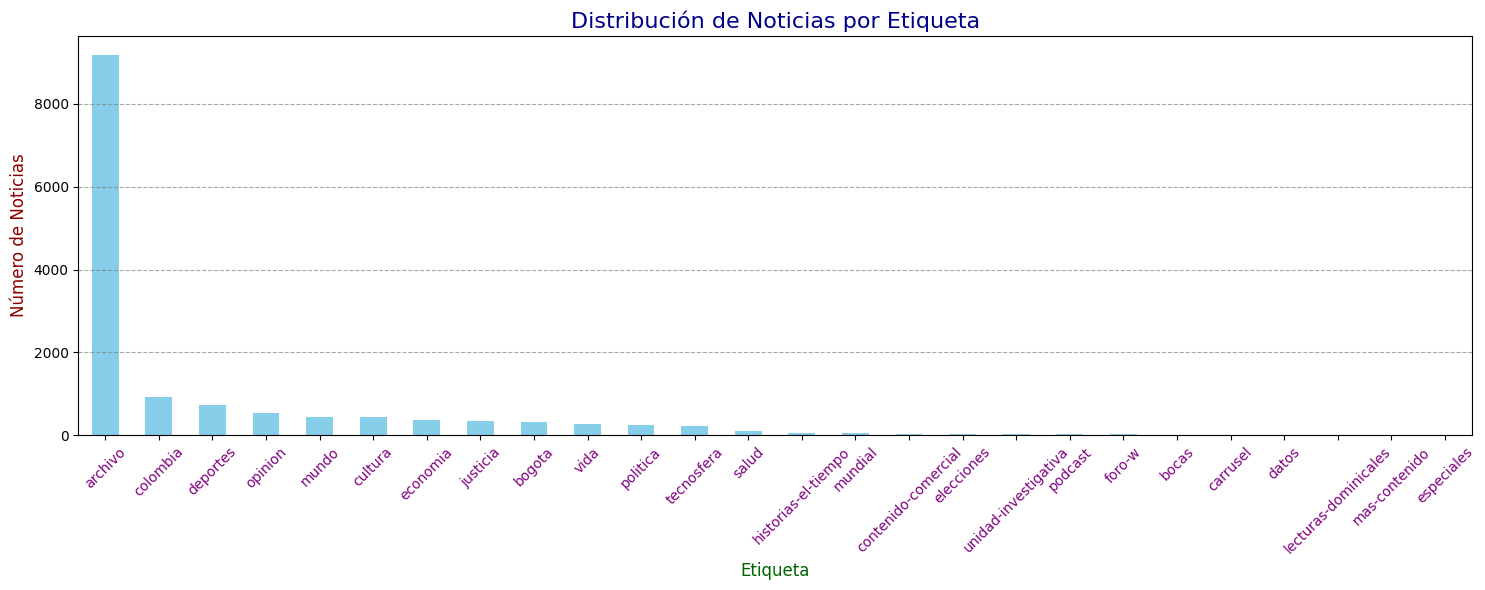

Etiqueta
archivo                 9187
colombia                 934
deportes                 727
opinion                  532
mundo                    446
cultura                  430
economia                 367
justicia                 343
bogota                   311
vida                     268
politica                 252
tecnosfera               214
salud                    106
historias-el-tiempo       57
mundial                   47
contenido-comercial       34
elecciones                33
unidad-investigativa      27
podcast                   20
foro-w                    18
bocas                     15
carrusel                   8
datos                      7
lecturas-dominicales       6
mas-contenido              4
especiales                 3
Name: count, dtype: int64

In [8]:
# Calcular la distribución de la columna 'Etiqueta'
etiqueta_distribution = data['Etiqueta'].value_counts()

# Graficar la distribución como un gráfico de barras
plt.figure(figsize=(15, 6))  # Configurar el tamaño de la figura
etiqueta_distribution.plot(kind='bar', color='skyblue')  # Cambiar el color de las barras
plt.title('Distribución de Noticias por Etiqueta', fontsize=16, color='darkblue')  # Cambiar el color del título
plt.xlabel('Etiqueta', fontsize=12, color='darkgreen')  # Cambiar el color de la etiqueta del eje X
plt.ylabel('Número de Noticias', fontsize=12, color='darkred')  # Cambiar el color de la etiqueta del eje Y
plt.xticks(rotation=45, fontsize=10, color='purple')  # Rotar etiquetas del eje X y cambiar su color
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')  # Cambiar el color de la cuadrícula
plt.tight_layout()  # Ajustar automáticamente el diseño para evitar solapamientos
plt.show()  # Mostrar el gráfico

# Mostrar los conteos de noticias por etiqueta
etiqueta_distribution

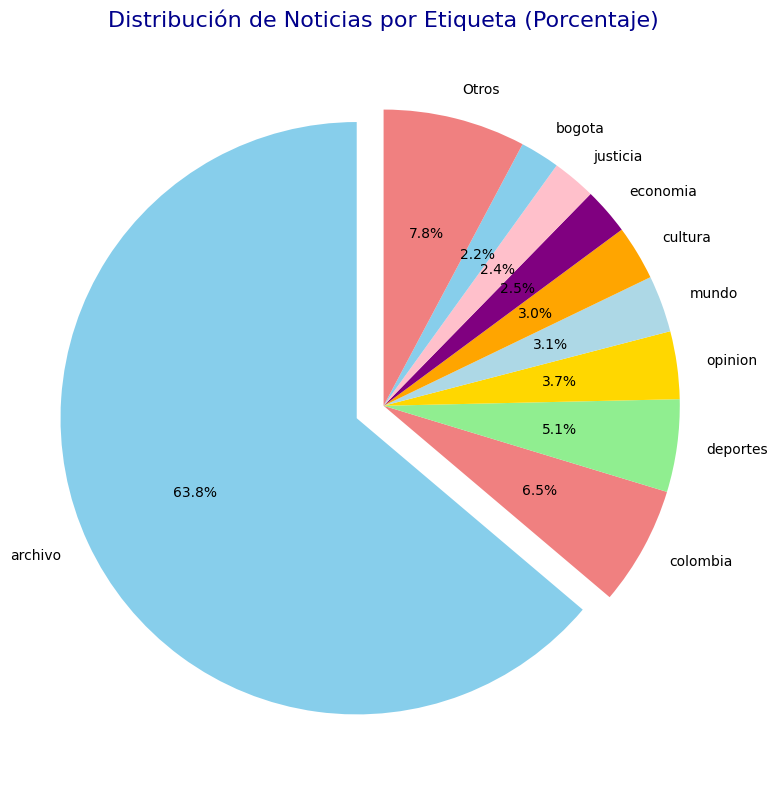

In [9]:
# Agrupar categorías menores al 2.4% en "Otros"
threshold = 2.1  # Porcentaje mínimo
total = etiqueta_distribution.sum()
etiqueta_distribution_percent = etiqueta_distribution / total * 100
otros = etiqueta_distribution_percent[etiqueta_distribution_percent < threshold].sum()

# Crear una nueva serie con "Otros" incluido
etiquetas_filtradas = etiqueta_distribution_percent[etiqueta_distribution_percent >= threshold]
etiquetas_filtradas['Otros'] = otros

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
etiquetas_filtradas.plot(
    kind='pie', 
    autopct='%1.1f%%',  # Mostrar porcentajes con un decimal
    startangle=90,  # Comenzar desde el ángulo 90
    colors=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightblue', 'orange', 'purple', 'pink'], # Colores personalizados
    explode=[0.1 if i == 0 else 0 for i in range(len(etiquetas_filtradas))]  # Resaltar la categoría más alta
)

plt.title('Distribución de Noticias por Etiqueta (Porcentaje)', fontsize=16, color='darkblue')
plt.ylabel('')  # Eliminar el título del eje Y
plt.tight_layout()
plt.show()

**Ejercicio 2**

Filtrado de datos



- Objetivo: Limitar el conjunto de datos a las categorías relevantes para garantizar que el modelo se entrene y evalúe en temas especializados.
  - 
Acciones 
Excluir las noticias que pertenecen a la categoría "archivo" y cualquier otra que no esté en las categorías de deportes, cultura, economía y justici .
Asegurarse de que el conjunto de datos resultante tenga  na distribución equilibrada para estas categorías, en la medida de lo posib
- e.
Contexto: Es importante filtrar los datos para enfocarnos en temas especializados porque algunas categorías pueden tener un discurso amplio y no se tratan de un tema especializado. Esto ayuda a mejorar la precisión del modelo al enfocarse en categorías bien definidas.

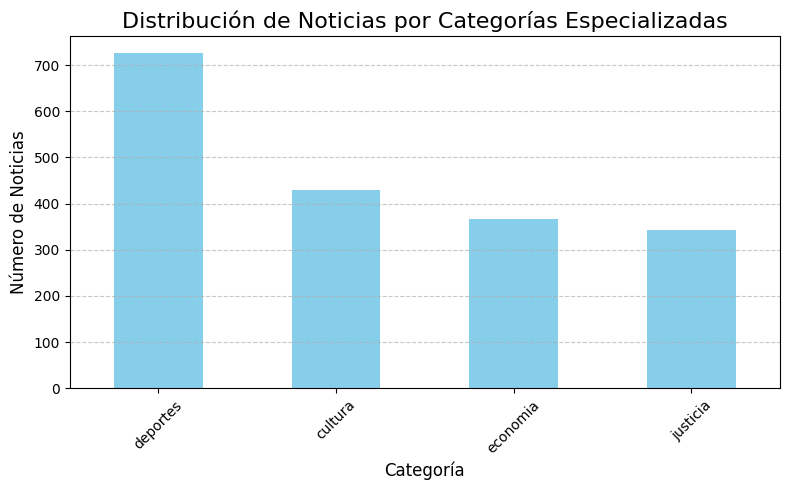

In [12]:
# Filtrar noticias por categorías relevantes excluyendo "archivo" y otras irrelevantes
categorias_relevantes = ['deportes', 'cultura', 'economia', 'justicia']
datos_filtrados = data[data['Etiqueta'].isin(categorias_relevantes)]

# Verificar la distribución de las categorías filtradas
distribucion_filtrada = datos_filtrados['Etiqueta'].value_counts()

# Visualizar la distribución de las categorías filtradas
plt.figure(figsize=(8, 5))
distribucion_filtrada.plot(kind='bar', color='skyblue')
plt.title('Distribución de Noticias por Categorías Especializadas', fontsize=16)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Número de Noticias', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
datos_filtrados

,Columna1,Enlaces,Título,info,contenido,Etiqueta
10487,10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...,...
12467,12467,https://www.eltiempo.com/justicia/servicios/po...,Más de 70 mil policías apoyan jornada de aisla...,Miisterio de Defensa activó dispositivo especi...,"El ministro de la Defensa, Carlos Holmes Truj...",justicia
12468,12468,https://www.eltiempo.com/justicia/servicios/pr...,Habrá proyecto conjunto para superar la crisis...,Se revisarán “conductas antisociales” que se h...,Después de varios contrapunteos sobre la mejor...,justicia
12469,12469,https://www.eltiempo.com/justicia/servicios/qu...,¿Qué hacer en caso de un accidente de tránsito...,EL TIEMPO y la Unilibre responden a esta y otr...,El TIempo y la Universidad Libre se aliaron pa...,justicia
12470,12470,https://www.eltiempo.com/justicia/servicios/su...,Otorgan subsidios a tres obreros del edificio ...,También la esposa de una de las víctimas recib...,Tres trabajadores del edificio Portales Blas d...,justicia


Submuestreo

C:\Users\dfbat\AppData\Local\Temp\ipykernel_16644\3416885403.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


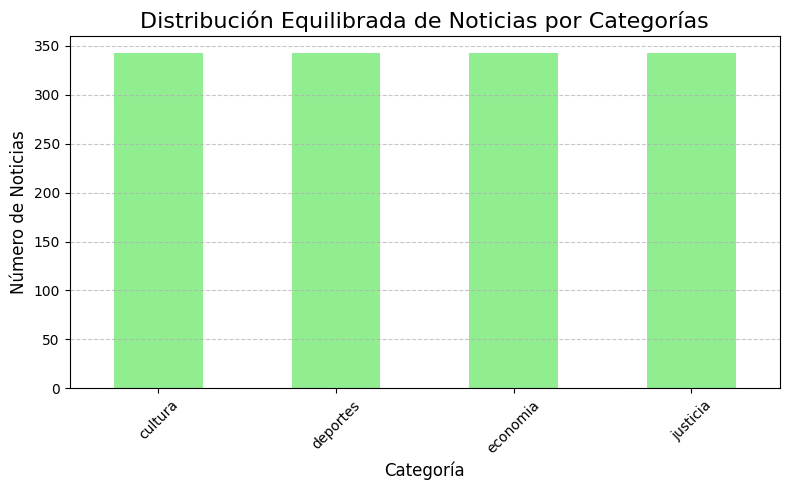

Etiqueta
cultura     343
deportes    343
economia    343
justicia    343
Name: count, dtype: int64


In [15]:
# Identificar el tamaño mínimo entre las categorías
min_count = datos_filtrados['Etiqueta'].value_counts().min()

# Submuestrear cada categoría para que todas tengan la misma cantidad de datos
datos_balanceados = (
    datos_filtrados.groupby('Etiqueta', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)

# Verificar la nueva distribución equilibrada
distribucion_balanceada = datos_balanceados['Etiqueta'].value_counts()

# Visualizar la distribución equilibrada
plt.figure(figsize=(8, 5))
distribucion_balanceada.plot(kind='bar', color='lightgreen')
plt.title('Distribución Equilibrada de Noticias por Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Número de Noticias', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar la nueva distribución en la consola
print(distribucion_balanceada)

In [16]:

datos_filtrados

,Columna1,Enlaces,Título,info,contenido,Etiqueta
10487,10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...,...
12467,12467,https://www.eltiempo.com/justicia/servicios/po...,Más de 70 mil policías apoyan jornada de aisla...,Miisterio de Defensa activó dispositivo especi...,"El ministro de la Defensa, Carlos Holmes Truj...",justicia
12468,12468,https://www.eltiempo.com/justicia/servicios/pr...,Habrá proyecto conjunto para superar la crisis...,Se revisarán “conductas antisociales” que se h...,Después de varios contrapunteos sobre la mejor...,justicia
12469,12469,https://www.eltiempo.com/justicia/servicios/qu...,¿Qué hacer en caso de un accidente de tránsito...,EL TIEMPO y la Unilibre responden a esta y otr...,El TIempo y la Universidad Libre se aliaron pa...,justicia
12470,12470,https://www.eltiempo.com/justicia/servicios/su...,Otorgan subsidios a tres obreros del edificio ...,También la esposa de una de las víctimas recib...,Tres trabajadores del edificio Portales Blas d...,justicia


In [17]:
datos_balanceados

,Columna1,Enlaces,Título,info,contenido,Etiqueta
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura
...,...,...,...,...,...,...
1367,12317,https://www.eltiempo.com/justicia/investigacio...,Llamado a interrogatorio por Hidroituango es e...,"Álvaro Villegas Moreno, citado por la Fiscalía...",Dentro de los llamados a a declarar por la Fi...,justicia
1368,12200,https://www.eltiempo.com/justicia/cortes/conse...,Consejo de Estado negó demanda por $ 4 mil mil...,Los demandantes aludían afectación patrimonial...,Cuatro comisionistas de bolsa que laboraron en...,justicia
1369,12235,https://www.eltiempo.com/justicia/cortes/proye...,Con cooperación internacional mejorarán educac...,Proyecto de cooperación con EE. UU. fortalecer...,Con el apoyo de la Embajada de los Estados Uni...,justicia
1370,12399,https://www.eltiempo.com/justicia/investigacio...,Las claves de la histórica jornada electoral d...,La mayor participación obedece a los efectos d...,Como ha sido la constante desde el 2002 –con l...,justicia


**Ejercicio 3**

Preprocesamiento de Texto
Objetivo: Preparar los datos textuales para el entrenamiento del modelo.

Acciones:

Convertir todo el texto a minúsculas para uniformidad.

Eliminar puntuación y números para reducir el ruido en los datos.

Eliminar palabras comunes (stop words) que no aportan significado específico al análisis.

Tokenizar el texto, es decir, dividir el texto en palabras individuales.

Aplicar padding a las secuencias de palabras para que todas tengan la misma longitud, facilitando el procesamiento por las redes neuronales.

**Preprocesamiento**

In [20]:
# Función para preprocesar texto
def preprocess_text(text):
    """
    Esta función realiza el preprocesamiento del texto.
    1. Convierte el texto a minúsculas.
    2. Elimina la puntuación.
    3. Elimina los números.
    4. Elimina los espacios en blanco adicionales.
    5. Elimina comilla simple (preguntar la profe si se deja esta funcionalidad jcc)

    Parámetros:
    text (str): El texto original.

    Retorna:
    str: El texto preprocesado.
    """
    #Eliminar comillas simple  ‘
    text = text.translate(str.maketrans('', '', "‘"))
     #Eliminar comillas simple  ’
    text = text.translate(str.maketrans('', '', "’"))
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar espacios en blanco adicionales
    text = text.strip()
    return text

# Aplicar preprocesamiento al contenido
## Deben eliminarse los valores nulos antes de aplicar el preprocesamiento
datos_balanceados = datos_balanceados.dropna(subset=['contenido'])

# Aplicar preprocesamiento al contenido
datos_balanceados['contenido_preprocesado'] = datos_balanceados['contenido'].apply(preprocess_text)

# Mostrar una vista previa de los datos preprocesados
display(datos_balanceados[['contenido', 'contenido_preprocesado']].head())

# Dimensiones de los datos

print(f'Dimensiones de los datos: {datos_balanceados.shape}')

C:\Users\dfbat\AppData\Local\Temp\ipykernel_16644\1826428134.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_balanceados['contenido_preprocesado'] = datos_balanceados['contenido'].apply(preprocess_text)


,contenido,contenido_preprocesado
0,"Siendo un niño, ‘El Sol de México’ se convirti...",siendo un niño el sol de méxico se convirtió e...
1,Las películas de Víctor Gaviria constituyen un...,las películas de víctor gaviria constituyen un...
2,"Del inagotable repertorio de las salsas, no cr...",del inagotable repertorio de las salsas no cre...
3,"La Casa 1537, ubicada en la calle del Colegio ...",la casa ubicada en la calle del colegio del c...
4,"Judas Priest, la banda británica fundamental e...",judas priest la banda británica fundamental en...


Dimensiones de los datos: (1371, 7)


In [21]:
datos_balanceados

,Columna1,Enlaces,Título,info,contenido,Etiqueta,contenido_preprocesado
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura,siendo un niño el sol de méxico se convirtió e...
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura,las películas de víctor gaviria constituyen un...
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura,del inagotable repertorio de las salsas no cre...
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura,la casa ubicada en la calle del colegio del c...
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura,judas priest la banda británica fundamental en...
...,...,...,...,...,...,...,...
1367,12317,https://www.eltiempo.com/justicia/investigacio...,Llamado a interrogatorio por Hidroituango es e...,"Álvaro Villegas Moreno, citado por la Fiscalía...",Dentro de los llamados a a declarar por la Fi...,justicia,dentro de los llamados a a declarar por la fi...
1368,12200,https://www.eltiempo.com/justicia/cortes/conse...,Consejo de Estado negó demanda por $ 4 mil mil...,Los demandantes aludían afectación patrimonial...,Cuatro comisionistas de bolsa que laboraron en...,justicia,cuatro comisionistas de bolsa que laboraron en...
1369,12235,https://www.eltiempo.com/justicia/cortes/proye...,Con cooperación internacional mejorarán educac...,Proyecto de cooperación con EE. UU. fortalecer...,Con el apoyo de la Embajada de los Estados Uni...,justicia,con el apoyo de la embajada de los estados uni...
1370,12399,https://www.eltiempo.com/justicia/investigacio...,Las claves de la histórica jornada electoral d...,La mayor participación obedece a los efectos d...,Como ha sido la constante desde el 2002 –con l...,justicia,como ha sido la constante desde el –con la so...


**Tokenización**

In [23]:
# Tokenización
datos_balanceados['tokens'] = datos_balanceados['contenido_preprocesado'].apply(word_tokenize)

# Mostrar una vista previa de los tokens
datos_balanceados[['contenido_preprocesado', 'tokens']].head()

C:\Users\dfbat\AppData\Local\Temp\ipykernel_16644\1677630900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_balanceados['tokens'] = datos_balanceados['contenido_preprocesado'].apply(word_tokenize)


,contenido_preprocesado,tokens
0,siendo un niño el sol de méxico se convirtió e...,"[siendo, un, niño, el, sol, de, méxico, se, co..."
1,las películas de víctor gaviria constituyen un...,"[las, películas, de, víctor, gaviria, constitu..."
2,del inagotable repertorio de las salsas no cre...,"[del, inagotable, repertorio, de, las, salsas,..."
3,la casa ubicada en la calle del colegio del c...,"[la, casa, ubicada, en, la, calle, del, colegi..."
4,judas priest la banda británica fundamental en...,"[judas, priest, la, banda, británica, fundamen..."


In [24]:
print("Contenido preprocesado: ", datos_balanceados['contenido_preprocesado'][0])
print("Tokens: ", datos_balanceados['tokens'][0])

Contenido preprocesado:  siendo un niño el sol de méxico se convirtió en un auténtico fenómeno en méxico que pronto arrasó en toda latinoamérica marcando a generaciones enteras  una estrella que luego de años de bache en su carrera regresó a la popularidad gracias a la serie basada en su vida empezó a cantar con apenas diez años y pronto se convirtió en todo un fenómeno en méxico y en una de las grandes voces de la canción romántica tanto es así que aún no había cumplido quince años cuando recibió su primer grammy  por la canción me gustas tal como eres que interpretó a dúo con la escocesa sheena easton hoy tras cuatro décadas de carrera sigue siendo uno de los grandes representantes de la música mexicana y latina en el mundo “muy temprano luis miguel deja de ser un niño para ser un trabajador y uno sometido a una disciplina muy tenaz y claro eso le ha marcado su vida completamente en los aspectos positivos como desarrollar una carrera sólida tanto en los negativos como haberse visto p

In [25]:
datos_balanceados

,Columna1,Enlaces,Título,info,contenido,Etiqueta,contenido_preprocesado,tokens
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura,siendo un niño el sol de méxico se convirtió e...,"[siendo, un, niño, el, sol, de, méxico, se, co..."
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura,las películas de víctor gaviria constituyen un...,"[las, películas, de, víctor, gaviria, constitu..."
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura,del inagotable repertorio de las salsas no cre...,"[del, inagotable, repertorio, de, las, salsas,..."
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura,la casa ubicada en la calle del colegio del c...,"[la, casa, ubicada, en, la, calle, del, colegi..."
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura,judas priest la banda británica fundamental en...,"[judas, priest, la, banda, británica, fundamen..."
...,...,...,...,...,...,...,...,...
1367,12317,https://www.eltiempo.com/justicia/investigacio...,Llamado a interrogatorio por Hidroituango es e...,"Álvaro Villegas Moreno, citado por la Fiscalía...",Dentro de los llamados a a declarar por la Fi...,justicia,dentro de los llamados a a declarar por la fi...,"[dentro, de, los, llamados, a, a, declarar, po..."
1368,12200,https://www.eltiempo.com/justicia/cortes/conse...,Consejo de Estado negó demanda por $ 4 mil mil...,Los demandantes aludían afectación patrimonial...,Cuatro comisionistas de bolsa que laboraron en...,justicia,cuatro comisionistas de bolsa que laboraron en...,"[cuatro, comisionistas, de, bolsa, que, labora..."
1369,12235,https://www.eltiempo.com/justicia/cortes/proye...,Con cooperación internacional mejorarán educac...,Proyecto de cooperación con EE. UU. fortalecer...,Con el apoyo de la Embajada de los Estados Uni...,justicia,con el apoyo de la embajada de los estados uni...,"[con, el, apoyo, de, la, embajada, de, los, es..."
1370,12399,https://www.eltiempo.com/justicia/investigacio...,Las claves de la histórica jornada electoral d...,La mayor participación obedece a los efectos d...,Como ha sido la constante desde el 2002 –con l...,justicia,como ha sido la constante desde el –con la so...,"[como, ha, sido, la, constante, desde, el, –co..."


**StopWords**

In [27]:
# Eliminación stop words
stop_words = set(stopwords.words('spanish'))
datos_balanceados['tokens_sin_stopwords'] = datos_balanceados['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

#vista previa de los tokens sin stop words
datos_balanceados[['tokens', 'tokens_sin_stopwords']].head()

C:\Users\dfbat\AppData\Local\Temp\ipykernel_16644\3407453061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_balanceados['tokens_sin_stopwords'] = datos_balanceados['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


,tokens,tokens_sin_stopwords
0,"[siendo, un, niño, el, sol, de, méxico, se, co...","[siendo, niño, sol, méxico, convirtió, auténti..."
1,"[las, películas, de, víctor, gaviria, constitu...","[películas, víctor, gaviria, constituyen, capí..."
2,"[del, inagotable, repertorio, de, las, salsas,...","[inagotable, repertorio, salsas, creo, recorda..."
3,"[la, casa, ubicada, en, la, calle, del, colegi...","[casa, ubicada, calle, colegio, centro, histór..."
4,"[judas, priest, la, banda, británica, fundamen...","[judas, priest, banda, británica, fundamental,..."


In [28]:

datos_balanceados.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta,contenido_preprocesado,tokens,tokens_sin_stopwords
0,10909,https://www.eltiempo.com/cultura/musica-y-libr...,"Luis Miguel, 50 años de un sol sin ocaso",'El Sol de México' cumple 50 años. Su historia...,"Siendo un niño, ‘El Sol de México’ se convirti...",cultura,siendo un niño el sol de méxico se convirtió e...,"[siendo, un, niño, el, sol, de, méxico, se, co...","[siendo, niño, sol, méxico, convirtió, auténti..."
1,10562,https://www.eltiempo.com/cultura/cine-y-tv/cri...,Críticamente: Aquí y ahora,Las películas de Víctor Gaviria constituyen un...,Las películas de Víctor Gaviria constituyen un...,cultura,las películas de víctor gaviria constituyen un...,"[las, películas, de, víctor, gaviria, constitu...","[películas, víctor, gaviria, constituyen, capí..."
2,10664,https://www.eltiempo.com/cultura/gastronomia/c...,Mejor con chimichurri / El Caldero,¿Dónde encontrar esa buena salsa para aderezar...,"Del inagotable repertorio de las salsas, no cr...",cultura,del inagotable repertorio de las salsas no cre...,"[del, inagotable, repertorio, de, las, salsas,...","[inagotable, repertorio, salsas, creo, recorda..."
3,10517,https://www.eltiempo.com/cultura/arte-y-teatro...,Secretos coloniales de la Casa 1537 de Cartagena,"Este sitio, que fue catedral, colegio y hospit...","La Casa 1537, ubicada en la calle del Colegio ...",cultura,la casa ubicada en la calle del colegio del c...,"[la, casa, ubicada, en, la, calle, del, colegi...","[casa, ubicada, calle, colegio, centro, histór..."
4,10848,https://www.eltiempo.com/cultura/musica-y-libr...,"Judas Priest, Helloween y Kreator estarán en e...",El festival será el 26 de octubre en el Hipódr...,"Judas Priest, la banda británica fundamental e...",cultura,judas priest la banda británica fundamental en...,"[judas, priest, la, banda, británica, fundamen...","[judas, priest, banda, británica, fundamental,..."


**Padding**

In [30]:
# con esta aplicacion de padding no se agrega columna al data set y se guarda en una variable llamda padded_sequences, asi la tien el profe en ela guia 2. mirar si se da asi o como aplciada anterisomente que agrega dos columnas la data set
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paso 1: Crear el tokenizador y ajustarlo a las palabras de tokens_sin_stopwords
tokenizer = Tokenizer()
tokenizer.fit_on_texts(datos_balanceados['tokens_sin_stopwords'])

# Extraer el vocabulario generado (word_index)
word_index = tokenizer.word_index
#print(f"Vocabulario generado (word_index): {word_index}")

# Paso 2: Convertir las palabras a índices numéricos
sequences = tokenizer.texts_to_sequences(datos_balanceados['tokens_sin_stopwords'])

# Paso 3: Aplicar padding y guardar en la variable padded_sequences
max_len = 200  # Longitud máxima para el padding 
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Mostrar los resultados
print(padded_sequences[:5])  # Muestra las primeras 5 secuencias con padding

ModuleNotFoundError: No module named 'tensorflow'